# Deployment of Machine Learning Models

We are going to use the churn prediction model from chapters 4 and 5. To make things easier, we are going to reuse the notebook from chapter 04, adding a section concerning the deployment of the model to web service. 


In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [39]:
df = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
print(len(df))
df.T

7043


,0,1,2,3,4,5,6,7,8,9,...,7033,7034,7035,7036,7037,7038,7039,7040,7041,7042
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU,9305-CDSKC,1452-KIOVK,6713-OKOMC,7892-POOKP,6388-TABGU,...,9767-FFLEM,0639-TSIQW,8456-QDAVC,7750-EYXWZ,2569-WGERO,6840-RESVB,2234-XADUH,4801-JZAZL,8361-LTMKD,3186-AJIEK
gender,Female,Male,Male,Male,Female,Female,Male,Female,Female,Male,...,Male,Female,Male,Female,Female,Male,Female,Female,Male,Male
SeniorCitizen,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Partner,Yes,No,No,No,No,No,No,No,Yes,No,...,No,No,No,No,No,Yes,Yes,Yes,Yes,No
Dependents,No,No,No,No,No,No,Yes,No,No,Yes,...,No,No,No,No,No,Yes,Yes,Yes,No,No
tenure,1,34,2,45,2,8,22,10,28,62,...,38,67,19,12,72,24,72,11,4,66
PhoneService,No,Yes,Yes,No,Yes,Yes,Yes,No,Yes,Yes,...,Yes,Yes,Yes,No,Yes,Yes,Yes,No,Yes,Yes
MultipleLines,No phone service,No,No,No phone service,No,Yes,Yes,No phone service,Yes,No,...,No,Yes,No,No phone service,No,Yes,Yes,No phone service,Yes,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic,Fiber optic,Fiber optic,DSL,Fiber optic,DSL,...,Fiber optic,Fiber optic,Fiber optic,DSL,No,DSL,Fiber optic,DSL,Fiber optic,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No,No,No,Yes,No,Yes,...,No,Yes,No,No,No internet service,Yes,No,Yes,No,Yes


### Data preprocessing

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


The 'TotalCharges' column has the wrong type: it should be numeric. This is due to the presence of white spaces in the place of missing values.

In [41]:
total_charges = pd.to_numeric(df.TotalCharges, errors='coerce')
df[total_charges.isnull()][['customerID', 'TotalCharges']]

,customerID,TotalCharges
488,4472-LVYGI,
753,3115-CZMZD,
936,5709-LVOEQ,
1082,4367-NUYAO,
1340,1371-DWPAZ,
3331,7644-OMVMY,
3826,3213-VVOLG,
4380,2520-SGTTA,
5218,2923-ARZLG,
6670,4075-WKNIU,


Let's fix that:

In [42]:
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')
df.TotalCharges = df.TotalCharges.fillna(0)
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

It is better practice to make the column names uniform by lowercasing everything and replacing spaces with underscores. This way we remove all the inconsistencies in the data.

In [43]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
string_columns = list(df.dtypes[df.dtypes == 'object'].index)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

df.columns

Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'tenure', 'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges', 'churn'],
      dtype='object')

Now, let's transform the target column 'churn' to integer type.

In [44]:
df.churn = (df.churn == 'yes').astype(int)

### Creating train and test sets

In [45]:
from sklearn.model_selection import train_test_split

#Create a train and a test set
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)

# Divide the test set into traind and validation
df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=11)

# Create the target arrays and remove the target columns from the train and validation datasets
y_train = df_train.churn.values #B
y_val = df_val.churn.values #B
del df_train['churn'] #C
del df_val['churn'] #C

### Exploratory data analysis

We begin by looking at missing values:

In [46]:
df_train_full.isnull().sum()

customerid          0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

In [47]:
df_train_full.churn.value_counts()

0    4113
1    1521
Name: churn, dtype: int64

We have an imbalanced dataset.

Let's separate numerical and categorical columns:

In [48]:
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
               'phoneservice', 'multiplelines', 'internetservice',
               'onlinesecurity', 'onlinebackup', 'deviceprotection',
               'techsupport', 'streamingtv', 'streamingmovies',
               'contract', 'paperlessbilling', 'paymentmethod']

numerical = ['tenure', 'monthlycharges', 'totalcharges']

Checking how many unique values each categorical column have:

In [49]:
df_train_full[categorical].nunique()

gender              2
seniorcitizen       2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
dtype: int64

### Feature importance
Churn rate and risk ratio:

In [50]:
from IPython.display import display

global_mean = df_train_full.churn.mean() # Rate of positives

for col in categorical:
    df_group = df_train_full.groupby(by=col).churn.agg(['mean'])
    df_group['diff'] = df_group['mean'] - global_mean
    df_group['risk'] = df_group['mean'] / global_mean
    display(df_group)

,mean,diff,risk
gender,,,
female,0.276824,0.006856,1.025396
male,0.263214,-0.006755,0.974980


,mean,diff,risk
seniorcitizen,,,
0,0.242270,-0.027698,0.897403
1,0.413377,0.143409,1.531208


,mean,diff,risk
partner,,,
no,0.329809,0.059841,1.221659
yes,0.205033,-0.064935,0.759472


,mean,diff,risk
dependents,,,
no,0.313760,0.043792,1.162212
yes,0.165666,-0.104302,0.613651


,mean,diff,risk
phoneservice,,,
no,0.241316,-0.028652,0.893870
yes,0.273049,0.003081,1.011412


,mean,diff,risk
multiplelines,,,
no,0.257407,-0.012561,0.953474
no_phone_service,0.241316,-0.028652,0.893870
yes,0.290742,0.020773,1.076948


,mean,diff,risk
internetservice,,,
dsl,0.192347,-0.077621,0.712482
fiber_optic,0.425171,0.155203,1.574895
no,0.077805,-0.192163,0.288201


,mean,diff,risk
onlinesecurity,,,
no,0.420921,0.150953,1.559152
no_internet_service,0.077805,-0.192163,0.288201
yes,0.153226,-0.116742,0.567570


,mean,diff,risk
onlinebackup,,,
no,0.404323,0.134355,1.497672
no_internet_service,0.077805,-0.192163,0.288201
yes,0.217232,-0.052736,0.804660


,mean,diff,risk
deviceprotection,,,
no,0.395875,0.125907,1.466379
no_internet_service,0.077805,-0.192163,0.288201
yes,0.230412,-0.039556,0.853480


,mean,diff,risk
techsupport,,,
no,0.418914,0.148946,1.551717
no_internet_service,0.077805,-0.192163,0.288201
yes,0.159926,-0.110042,0.592390


,mean,diff,risk
streamingtv,,,
no,0.342832,0.072864,1.269897
no_internet_service,0.077805,-0.192163,0.288201
yes,0.302723,0.032755,1.121328


,mean,diff,risk
streamingmovies,,,
no,0.338906,0.068938,1.255358
no_internet_service,0.077805,-0.192163,0.288201
yes,0.307273,0.037305,1.138182


,mean,diff,risk
contract,,,
month-to-month,0.431701,0.161733,1.599082
one_year,0.120573,-0.149395,0.446621
two_year,0.028274,-0.241694,0.104730


,mean,diff,risk
paperlessbilling,,,
no,0.172071,-0.097897,0.637375
yes,0.338151,0.068183,1.252560


,mean,diff,risk
paymentmethod,,,
bank_transfer_(automatic),0.168171,-0.101797,0.622928
credit_card_(automatic),0.164339,-0.105630,0.608733
electronic_check,0.455890,0.185922,1.688682
mailed_check,0.193870,-0.076098,0.718121


We can make the following conclusions:
- There is not much difference between males and females, since for the gender column the diferences between churn rate and the global mean are close to 0, and the risks are close to 1 for both groups.
- Senior citizens tend to churn more, due to their higher diff and risk.
- People with a partner churn less than people with no partner.
- The phone service shows that both groups have low risk of churning, but people who don't use the phone service have a lower risk (diff=-0.028 and risk=0.89).
- Clients with no tech support tend to churn more than those who do.
- People with monthly contracts cancel the contract a lot more often than others, and people with two-year contacts churn very rarely.

This way, we can identify the features that can help us detecting churn.

#### Mutual information
For categorical variable, a good metric to measure correlation between variables is mutual information, which tells how much information we learn about one variable if we get to learn the value of the other variable.

Let's calculate mutual information between all categorical variables and the churn variable.

In [51]:
from sklearn.metrics import mutual_info_score

def calculate_mi(series):
    return mutual_info_score(series, df_train_full.churn)

df_mi = df_train_full[categorical].apply(calculate_mi)
df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')
df_mi

,MI
contract,0.098320
onlinesecurity,0.063085
techsupport,0.061032
internetservice,0.055868
onlinebackup,0.046923
deviceprotection,0.043453
paymentmethod,0.043210
streamingtv,0.031853
streamingmovies,0.031581
paperlessbilling,0.017589


Contract and gender are the features with the highest and lowest mutual informations respectively, which was expected due to our previous analysis.

#### Correlation
To measure the correlation between the churn variable and the numerical features, we can use Pearson's correlation.

In [52]:
df_train_full[numerical].corrwith(df_train_full.churn)

tenure           -0.351885
monthlycharges    0.196805
totalcharges     -0.196353
dtype: float64

- Tenure has a negative correlation, which means that the clients that have been using the services for long periods tend to churn less.
- Monthly charges have positive correlation, so clients that pay more tend to churn more. 
- The total charges has a negative correlation because clients that are using the services for more time have a higher number of charges, so the same conclusion from the tenure feature applies here. 

In [53]:
# plot histogram of churn rate

#### Feature engineering
Now that we've explored the data and indentified the most important features for our prediction, we have to do feature engineering in our dataset; more specifically, we need to transform categorical data into numerical data before training the model: this is one-hot encoding. To do this, we are going to use the DictVectorizer function of scikit-learn. 

In [54]:
train_dict = df_train[categorical + numerical].to_dict('records')
train_dict[0]

{'gender': 'male',
 'seniorcitizen': 0,
 'partner': 'yes',
 'dependents': 'no',
 'phoneservice': 'yes',
 'multiplelines': 'no',
 'internetservice': 'dsl',
 'onlinesecurity': 'yes',
 'onlinebackup': 'yes',
 'deviceprotection': 'yes',
 'techsupport': 'yes',
 'streamingtv': 'yes',
 'streamingmovies': 'yes',
 'contract': 'two_year',
 'paperlessbilling': 'yes',
 'paymentmethod': 'bank_transfer_(automatic)',
 'tenure': 71,
 'monthlycharges': 86.1,
 'totalcharges': 6045.9}

In [55]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)

# We also need to apply OHE to the validation dataset
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict) 

print(X_train[0])

[0.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 8.6100e+01 1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 0.0000e+00
 1.0000e+00 7.1000e+01 6.0459e+03]


We can look at the new features' names:

In [56]:
dv.get_feature_names_out()

array(['contract=month-to-month', 'contract=one_year',
       'contract=two_year', 'dependents=no', 'dependents=yes',
       'deviceprotection=no', 'deviceprotection=no_internet_service',
       'deviceprotection=yes', 'gender=female', 'gender=male',
       'internetservice=dsl', 'internetservice=fiber_optic',
       'internetservice=no', 'monthlycharges', 'multiplelines=no',
       'multiplelines=no_phone_service', 'multiplelines=yes',
       'onlinebackup=no', 'onlinebackup=no_internet_service',
       'onlinebackup=yes', 'onlinesecurity=no',
       'onlinesecurity=no_internet_service', 'onlinesecurity=yes',
       'paperlessbilling=no', 'paperlessbilling=yes', 'partner=no',
       'partner=yes', 'paymentmethod=bank_transfer_(automatic)',
       'paymentmethod=credit_card_(automatic)',
       'paymentmethod=electronic_check', 'paymentmethod=mailed_check',
       'phoneservice=no', 'phoneservice=yes', 'seniorcitizen',
       'streamingmovies=no', 'streamingmovies=no_internet_service',

### Classification Model
For this problem, we are going to use logistic regression model.

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression(solver='liblinear', random_state=1)

model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:,1]

churn = y_pred >= 0.5

score = accuracy_score(y_val, churn)

print("The accuracy is {:0.2f} %".format(100*score))

The accuracy is 80.16 %


#### Model interpretation
We can look at some of the features' coefficients to check their importances.

In [58]:
dict(zip(dv.get_feature_names_out(), model.coef_[0].round(3)))

{'contract=month-to-month': 0.563,
 'contract=one_year': -0.086,
 'contract=two_year': -0.599,
 'dependents=no': -0.03,
 'dependents=yes': -0.092,
 'deviceprotection=no': 0.1,
 'deviceprotection=no_internet_service': -0.116,
 'deviceprotection=yes': -0.106,
 'gender=female': -0.027,
 'gender=male': -0.095,
 'internetservice=dsl': -0.323,
 'internetservice=fiber_optic': 0.317,
 'internetservice=no': -0.116,
 'monthlycharges': 0.001,
 'multiplelines=no': -0.168,
 'multiplelines=no_phone_service': 0.127,
 'multiplelines=yes': -0.081,
 'onlinebackup=no': 0.136,
 'onlinebackup=no_internet_service': -0.116,
 'onlinebackup=yes': -0.142,
 'onlinesecurity=no': 0.258,
 'onlinesecurity=no_internet_service': -0.116,
 'onlinesecurity=yes': -0.264,
 'paperlessbilling=no': -0.213,
 'paperlessbilling=yes': 0.091,
 'partner=no': -0.048,
 'partner=yes': -0.074,
 'paymentmethod=bank_transfer_(automatic)': -0.027,
 'paymentmethod=credit_card_(automatic)': -0.136,
 'paymentmethod=electronic_check': 0.175,


## Model Evaluation
Now it is time to evaluate the model with different metrics for classification.

### Accuracy
We've already calculated the accuracy score, but for a threshold of 0.5. Let's evaluate it for other thresholds:

In [59]:
thresholds = np.linspace(0, 1, 11)
accuracies = []    
for t in thresholds:
    churn_t = y_pred >= t
    acc = accuracy_score(y_val, churn_t)
    accuracies.append(acc)
    print('%0.2f %0.3f' % (t, acc))

0.00 0.261
0.10 0.595
0.20 0.690
0.30 0.755
0.40 0.782
0.50 0.802
0.60 0.790
0.70 0.774
0.80 0.742
0.90 0.739
1.00 0.739


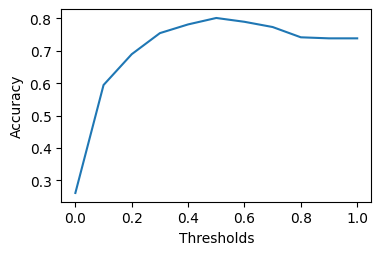

In [60]:
plt.figure(figsize=(4,2.5))
plt.plot(thresholds, accuracies)
plt.xlabel('Thresholds')
plt.ylabel('Accuracy')
plt.show()

Thus, the threshold of 0.5 yields the best accuracy value.

However, if we use as baseline a no-skill model that predicst False to all samples, the accuracy is:

In [61]:
size_val = len(y_val)
baseline = np.repeat(False, size_val)

print("Accuracy no-skill model: {:0.2f} %".format(100 * accuracy_score(y_val, baseline)))

Accuracy no-skill model: 73.87 %


Due to class imbalance, this metric is not the to use in this case. We have to evaluate the performance of the model with more suitable metrics.

### Precision and recall

- The precision of a model tells us how many of the positive predictions turned out to be correct. It’s the fraction of correctly predicted positive examples.
- Recall is the fraction of correctly classified positive examples among all positive examples. That is, how many churn clients the model was able to get classify correctly.

Let us look at the confusion matrix for this model, at threshold 0.5.

In [62]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

print(confusion_matrix(y_val, churn))
print("Precision: {:0.2f} %".format(100 * precision_score(y_val, churn)))
print("Recall: {:0.2f} %".format(100 * recall_score(y_val, churn)))

[[1202  172]
 [ 197  289]]
Precision: 62.69 %
Recall: 59.47 %


### ROC curve and AUC score

ROC AUC Score: 0.836


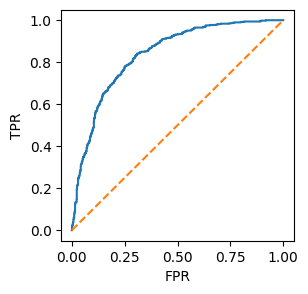

In [63]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_val, y_pred)

print("ROC AUC Score: {:0.3f}".format(roc_auc_score(y_val, y_pred))) 

plt.figure(figsize=(3,3))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

### Precision-recall curve

PR AUC Score: 0.610


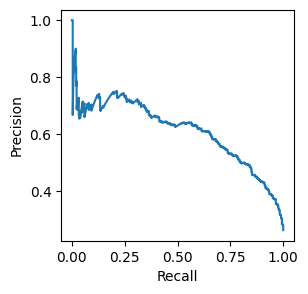

In [64]:
from sklearn.metrics import precision_recall_curve, auc

precisions, recalls, _ = precision_recall_curve(y_val, y_pred)

print("PR AUC Score: {:0.3f}".format(auc(recalls, precisions)))

plt.figure(figsize=(3,3))
plt.plot(recalls, precisions)
# plt.plot([0,1],[0,1],'--')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

## Parameter Tuning

We are going to perform parameter tuning using cross validation. For this, we are going to create some functions to make the process of preprocessing data and training/validating the model easier. 

In [65]:
def train(df, y, model):

    train_dict = df[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    dv.fit(train_dict)
    X = dv.transform(train_dict)

    model.fit(X, y)

    return model, dv

def predict(df, dv, model):

    val_dict = df[categorical + numerical].to_dict(orient='records')
    X_val = dv.transform(val_dict)
    y_pred = model.predict_proba(X_val)[:,1]

    return y_pred

First, we are going to perform cross-validation in the full train dataset, without tuning parameters.

In [66]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=10, shuffle=True, random_state=1)

auc_scores = []

for train_idx, val_idx in kfold.split(df_train_full):

    df_train = df_train_full.iloc[train_idx]
    df_val = df_train_full.iloc[val_idx]

    y_train = df_train['churn'].values
    y_val = df_val['churn'].values

    model = LogisticRegression(solver='liblinear', random_state=1)

    model, dv = train(df_train, y_train, model)
    y_pred = predict(df_val, dv, model)

    auc_scores.append(roc_auc_score(y_val, y_pred))

auc_mean = np.mean(auc_scores)
auc_std = np.std(auc_scores)
print(auc_scores)
print("AUC = {:0.3f} +/- {:0.3f}".format(auc_mean, auc_std))

[0.8493392490816277, 0.8413366336633662, 0.8590269587894291, 0.8334211176034894, 0.8242710918114144, 0.840959040959041, 0.8437154021491371, 0.8243595825426946, 0.8445679561286498, 0.8611811367685119]
AUC = 0.842 +/- 0.012


Notice that the mean of the AUCs of all the folds is very close to the value found before.

Now let's perform cross-validation, but iterating through different values of C:
- For each value of C, we are going to perform a 10-fold cross-validation, and calculate the mean AUC obtained;
- Then, we are going to save different the mean for each C and compare them.

In [67]:
auc_means_C = []
auc_std_C = []
for C in [0.001, 0.01, 0.1, 0.5, 1, 10]:
    
    auc_scores = []

    for train_idx, val_idx in kfold.split(df_train_full):

        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train['churn'].values
        y_val = df_val['churn'].values

        model = LogisticRegression(solver='liblinear', random_state=82, C=C)

        model, dv = train(df_train, y_train, model)
        y_pred = predict(df_val, dv, model)

        auc_scores.append(roc_auc_score(y_val, y_pred))

    auc_mean = np.mean(auc_scores)
    auc_std = np.std(auc_scores)
    auc_means_C.append(auc_mean)
    auc_std_C.append(auc_std)

    print("C = {}: AUC = {:0.4f} +/- {:0.4f}".format(C, auc_mean, auc_std))

C = 0.001: AUC = 0.8257 +/- 0.0160
C = 0.01: AUC = 0.8404 +/- 0.0121
C = 0.1: AUC = 0.8418 +/- 0.0117
C = 0.5: AUC = 0.8421 +/- 0.0123
C = 1: AUC = 0.8422 +/- 0.0119
C = 10: AUC = 0.8420 +/- 0.0123


From C = 0.1 , the AUC value does not improve anymore, so this will be the best regularization parameter. We choose C = 0.1 over the other values as smaller regularization values gives us additional assurance that the model will behave well on unseen data.

## Model testing
Finally, we have to train the model in the whole training data set and test it on unseen data.

In [68]:
model_final = LogisticRegression(solver='liblinear', random_state=82, C=0.1)

y_train_full = df_train_full['churn'].values
y_test = df_test['churn'].values

model, dv = train(df_train_full, y_train_full, model_final)
y_pred_final = predict(df_test, dv, model)

print("Test AUC: {:0.3f}".format(roc_auc_score(y_test, y_pred_final)))

Test AUC: 0.858


This AUC score is very similar to that found during training, so the model is generalizing well.

## Model Deployment

Before dealing with model deployment, we are going to create a function that uses our model to predict the probability of churning for a single customer.

In [69]:
def predict_single(customer, dv, model):
    X = dv.transform([customer])
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred[0]

Let's use the following customer as an example:

In [70]:
customer = {
'customerid': '8879-zkjof',
'gender': 'female',
'seniorcitizen': 0,
'partner': 'no',
'dependents': 'no',
'tenure': 41,
'phoneservice': 'yes',
'multiplelines': 'no',
'internetservice': 'dsl',
'onlinesecurity': 'yes',
'onlinebackup': 'no',
'deviceprotection': 'yes',
'techsupport': 'yes',
'streamingtv': 'yes',
'streamingmovies': 'yes',
'contract': 'one_year',
'paperlessbilling': 'yes',
'paymentmethod': 'bank_transfer_(automatic)',
'monthlycharges': 79.85,
'totalcharges': 3320.75,
}

predict_single(customer, dv, model)

0.06349852904587676

### Saving the model
To use this model in different files, we need to save it. We are going to do that using ```pickle```.

In [71]:
import pickle

with open('churn-model.bin', 'wb') as f_out:
    pickle.dump((dv, model), f_out)

Now, we have to create a Flask app to test the model. It was created on the ```chur_serving.py``` script. Let's send a request to it with our customer.

In [76]:
import requests

url = 'http://localhost:9696/predict'
response = requests.post(url, json=customer)
result = response.json()
print(result)

{'churn': False, 'churn_probability': 0.06349852904587676}


The ```results``` variable contains the response from the churn service.